# Preprossing Data - Products & Pricing

In [2]:
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
import re
import seaborn as sns
from IPython.display import display, HTML, Image

In [3]:
pricing_data = 'DatafinitiElectronicsProductsPricingData.csv'
df = pd.read_csv (pricing_data)
pd.options.display.width = 0

In [4]:
print("Dataframe Dimensions:",df.shape)
pd.set_option('display.max_columns', 500)

Dataframe Dimensions: (14592, 31)


In [47]:
# Information on null values
tab_info = pd.DataFrame(df.dtypes).T.rename(index={0: 'column type'})
tab_info = pd.concat([tab_info, pd.DataFrame(df.isnull().sum()).T.rename(index={0: 'null values (nb)'}),
                     pd.DataFrame(df.isnull().sum() / df.shape[0] * 100).T.rename(index={0: 'null values (%)'})])

print('-' * 10 + " Display information about column types and number of null values " + '-' * 10)
print(tab_info)


---------- Display information about column types and number of null values ----------
                 Imp_count   brand condition currency dateAdded dateSeen  \
column type          int64  object    object   object    object   object   
null values (nb)         0       0         0        0         0        0   
null values (%)        0.0     0.0       0.0      0.0       0.0      0.0   

                 dateUpdated disc_price i_description imageURLs  isSale  \
column type           object    float64        object    object  object   
null values (nb)           0          0             0         0       0   
null values (%)          0.0        0.0           0.0       0.0     0.0   

                 manufacturer merchant    name    price   shipping sourceURLs  \
column type            object   object  object  float64     object     object   
null values (nb)        20309        0       0        0      21277          0   
null values (%)     46.970258      0.0     0.0      0.0  49.2090

In [8]:
#Drop columns that start with Unnamed
df = df[df.columns.drop(list(df.filter(regex='Unnamed*')))]
#Drop columns that are not going to be used
df = df[df.columns.drop(['sourceURLs','prices.availability','asins','manufacturerNumber','upc', 'primaryCategories','keys','id','ean'])]


#Change the name of columns
columns_to_change = {}
for column in df.columns:
    if column.startswith("prices."):
        columns_to_change[column] = column[7:]
df.rename(columns=columns_to_change, inplace=True)
df.rename(columns = {'amountMax':'price', 'amountMin':'disc_price','categories':'i_description'}, inplace = True)

In [9]:
df.columns

Index(['price', 'disc_price', 'condition', 'currency', 'dateSeen', 'isSale',
       'merchant', 'shipping', 'sourceURLs', 'brand', 'i_description',
       'dateAdded', 'dateUpdated', 'imageURLs', 'manufacturer', 'name',
       'weight'],
      dtype='object')

In [10]:
#Sale Prices Check
df['isSale'] = np.where(df['price']> df['disc_price'],"Yes", "No")

# Normalization (Merchant, Condition of Product, Shipping Method)

In [14]:
# utilize source url for the Merchant accuracy, 
merchant_ab= df['sourceURLs']
df['merchant'] = np.where(merchant_ab.str.contains('bhphotovideo', flags=re.IGNORECASE), "bhphotovideo.com",
                 np.where(merchant_ab.str.contains('eBay|e bay', flags=re.IGNORECASE), "ebay.com",
                 np.where(merchant_ab.str.contains('Amazon',flags=re.IGNORECASE), "Amazon.com", 
                 np.where(merchant_ab.str.contains('Bestbuy',flags=re.IGNORECASE), "Bestbuy.com",
                 np.where(merchant_ab.str.contains('Homedepot',flags=re.IGNORECASE), "homedepot.com",
                 np.where(merchant_ab.str.contains('newegg',flags=re.IGNORECASE), "newegg.com",
                 np.where(merchant_ab.str.contains('kmart',flags=re.IGNORECASE), "kmart.com",
                 np.where(merchant_ab.str.contains('frys',flags=re.IGNORECASE), "frys.com",
                 np.where(merchant_ab.str.contains('cdw',flags=re.IGNORECASE), "cdw.com",
                 np.where(merchant_ab.str.contains('target',flags=re.IGNORECASE), "target.com",
                 np.where(merchant_ab.str.contains('overstock',flags=re.IGNORECASE), "overstock.com",
                 np.where(merchant_ab.str.contains('barcodable',flags=re.IGNORECASE), "barcodable.com",
                 np.where(merchant_ab.str.contains('kohls',flags=re.IGNORECASE), "kohls.com",
                 np.where(merchant_ab.str.contains('sears',flags=re.IGNORECASE), "sears.com",
                 np.where(merchant_ab.str.contains('Wal-mart|Walmart',flags=re.IGNORECASE), "Walmart.com","Other")))))))))))))))


In [15]:
m = df['merchant'].value_counts()
print("Merchant Percentage\n{}\n{}\nMerchant values count\n{}\n{}".format(
      50*"-", m / len(df.index) * 100, 50*"-", m))

Merchant Percentage
--------------------------------------------------
Bestbuy.com         30.838816
Walmart.com         25.479715
bhphotovideo.com    18.893914
ebay.com            14.624452
Amazon.com           7.147752
target.com           0.842928
frys.com             0.507127
barcodable.com       0.322094
newegg.com           0.308388
cdw.com              0.294682
Other                0.260417
homedepot.com        0.157621
kmart.com            0.123355
kohls.com            0.075384
sears.com            0.068531
overstock.com        0.054825
Name: merchant, dtype: float64
Merchant values count
--------------------------------------------------
Bestbuy.com         4500
Walmart.com         3718
bhphotovideo.com    2757
ebay.com            2134
Amazon.com          1043
target.com           123
frys.com              74
barcodable.com        47
newegg.com            45
cdw.com               43
Other                 38
homedepot.com         23
kmart.com             18
kohls.com           

In [16]:
#Products filtered by condition 
condition= df['condition'].fillna('None')
df['condition'] = np.where(condition.str.contains('new', flags=re.IGNORECASE), "New",
                           np.where(condition.str.contains('refurbished',flags=re.IGNORECASE), "Refurbished", 
                           np.where(condition.str.contains('pre-owned|used',flags=re.IGNORECASE), "Used",condition)))
                  
c = df['condition'].value_counts()
print("Product Condition Percentage\n{}\n{}\nProduct Condition values count\n{}\n{}".format(
      50*"-", c / len(df.index) * 100, 50*"-", c))

Product Condition Percentage
--------------------------------------------------
New                         85.649671
None                         9.614857
Used                         3.125000
Refurbished                  1.576206
For parts or not working     0.034265
Name: condition, dtype: float64
Product Condition values count
--------------------------------------------------
New                         12498
None                         1403
Used                          456
Refurbished                   230
For parts or not working        5
Name: condition, dtype: int64


In [17]:
# date seen of ad
print("Dataframe Dimensions without date impressions rows:", df.shape)
display(df[['name','dateSeen']][:5])

Dataframe Dimensions without date impressions rows: (14592, 17)


,name,dateSeen
0,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,"2017-03-30T06:00:00Z,2017-03-10T22:00:00Z,2017..."
1,Boytone - 2500W 2.1-Ch. Home Theater System - ...,2017-12-14T06:00:00Z
2,Boytone - 2500W 2.1-Ch. Home Theater System - ...,2017-09-08T05:00:00Z
3,Boytone - 2500W 2.1-Ch. Home Theater System - ...,2017-10-10T05:00:00Z
4,Boytone - 2500W 2.1-Ch. Home Theater System - ...,2017-08-28T07:00:00Z


In [22]:
#Split dates and add count of impressions per product as df['Imp_count']
hour_scratch=[]
date_count=[]

for i in df['dateSeen']:
    time_= i.split(",")
    hour_scratch.append(time_)
    date_count.append(len(time_))
                      
df['Imp_count']= date_count                     
df['Date_imp'] = hour_scratch

In [23]:
#date expansion
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col: np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res
df = explode(df , ['Date_imp'], fill_value='')

In [33]:
#Adding month, week, and day
#Convert df['Date_imp'] to Datetime
df['Date_imp']= pd.to_datetime(df['Date_imp'], errors='coerce')
df['Date_imp_d']= df['Date_imp'].dt.strftime('%Y/%m/%d')
df['day_name']= df['Date_imp'].dt.strftime('%A')
df['year']= df['Date_imp'].dt.year
df['month']= df['Date_imp'].dt.month
df['month_name']= df['Date_imp'].dt.strftime('%B')
df['day']= df['Date_imp'].dt.day
df['week_number'] = df['Date_imp'].dt.isocalendar().week
#Checking the weekday df['WeekDay'] = df['Date_imp'].dt.weekday


print("Dataframe dimensions with impressions:" ,df.shape)

Dataframe dimensions with impressions: (43238, 29)


In [34]:
df[['Date_imp','Date_imp_d','day_name','month_name']][:5]

,Date_imp,Date_imp_d,day_name,month_name
0,2017-03-30 06:00:00+00:00,2017/03/30,Thursday,March
1,2017-03-10 22:00:00+00:00,2017/03/10,Friday,March
2,2017-03-04 10:00:00+00:00,2017/03/04,Saturday,March
3,2017-03-03 14:00:00+00:00,2017/03/03,Friday,March
4,2017-12-14 06:00:00+00:00,2017/12/14,Thursday,December


In [35]:
df.head(2)

,Imp_count,brand,condition,currency,dateAdded,dateSeen,dateUpdated,disc_price,i_description,imageURLs,isSale,manufacturer,merchant,name,price,shipping,sourceURLs,weight,Date_imp,Date_imp_d,Day_n,year,month,month_n,day,Week_Number,day_name,month_name,week_number
0,4,Sanus,New,USD,2015-04-13T12:00:51Z,"2017-03-30T06:00:00Z,2017-03-10T22:00:00Z,2017...",2018-05-12T18:59:48Z,104.99,"Audio & Video Accessories,TV Mounts,TV Accesso...",https://images-na.ssl-images-amazon.com/images...,No,NaN,Bestbuy.com,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,104.99,NaN,http://www.bestbuy.com/site/sanus-tv-wall-moun...,32.8 pounds,2017-03-30 06:00:00+00:00,2017/03/30,Thursday,2017,3,March,30,13,Thursday,March,13
1,4,Sanus,New,USD,2015-04-13T12:00:51Z,"2017-03-30T06:00:00Z,2017-03-10T22:00:00Z,2017...",2018-05-12T18:59:48Z,104.99,"Audio & Video Accessories,TV Mounts,TV Accesso...",https://images-na.ssl-images-amazon.com/images...,No,NaN,Bestbuy.com,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,104.99,NaN,http://www.bestbuy.com/site/sanus-tv-wall-moun...,32.8 pounds,2017-03-10 22:00:00+00:00,2017/03/10,Friday,2017,3,March,10,10,Friday,March,10


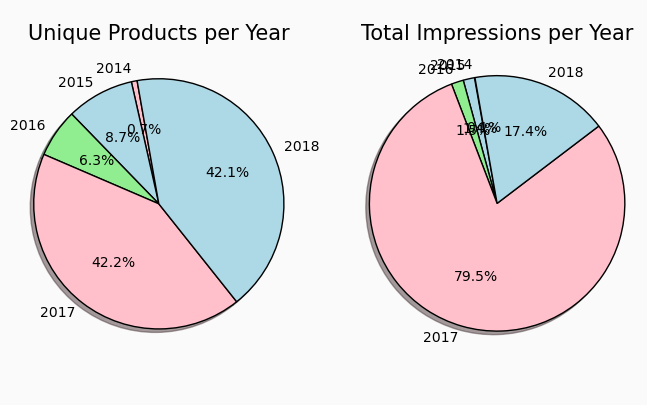

In [43]:

# Setting a background color for the graphs
bg_color = (0.98, 0.98, 0.98)
plt.rcParams['figure.facecolor'] = bg_color
plt.rcParams['axes.facecolor'] = bg_color

# Creating impressions pie chart data frame
colors = ['pink', 'lightblue', 'lightgreen']
pie_prod = df.groupby('year').agg({'name':'nunique','Date_imp':'count'}).reset_index()
pie_prod = pie_prod.rename(columns={'year':'Year', 'name':'Product', 'Date_imp':'Impressions'})
x = pie_prod['Year']
unique_prod = pie_prod['Product']
Imp_count = pie_prod['Impressions']
percent_unique = 100. * unique_prod / unique_prod.sum()
percent_imp = 100. * Imp_count / Imp_count.sum()

# Chart subplots
plt.rcParams['figure.figsize'] = [8, 5]
plt.subplot(121)
plt.pie(unique_prod, labels=x, autopct='%1.1f%%', startangle=100, shadow=True, colors=colors,
        wedgeprops={"edgecolor": "k", 'linewidth': 1, 'antialiased': True})
plt.title('Unique Products per Year', fontsize=15, y=.9)
plt.axis('equal')

plt.subplot(122)
plt.pie(Imp_count, labels=x, autopct='%1.1f%%', startangle=100, shadow=True, colors=colors,
        wedgeprops={"edgecolor": "k", 'linewidth': 1, 'antialiased': True})
plt.title('Total Impressions per Year', fontsize=15, y=.9)
plt.axis('equal')

plt.show()


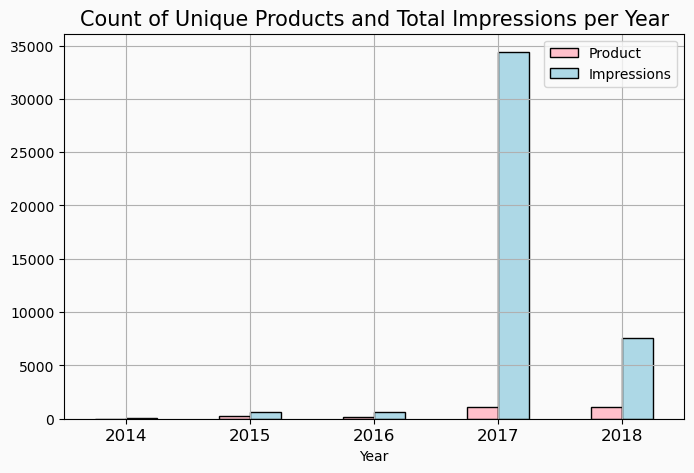

In [52]:
# Set colors for 'Product' and 'Impressions'
colors = ['pink', 'lightblue']
# Bar plot
pie_prod.plot.bar(x='Year', rot=0, grid=True, edgecolor='k', color=colors)
plt.title('Count of Unique Products and Total Impressions per Year', fontsize=15)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=10)
plt.show()

In [59]:
# Select only 2017 Impressions for analysis
df_2017 = df[df['year'] == 2017].copy()
print(f"New DataFrame Dimensions with only 2017 Impressions: {len(df_2017)}")

# Add Discount percentage of products with impressions
df_2017['Disc_percentage'] = round(1 - (df_2017['disc_price'] / df_2017['price']), 2)

# Create a summary table
summary_tab = pd.DataFrame({
    'column type': df_2017.dtypes,
    'Unique Values': df_2017.nunique(),
    'Total Count': df_2017.count(),
    'null values (nb)': df_2017.isnull().sum(),
    'null values (%)': df_2017.isnull().sum() / len(df_2017) * 100
}).transpose()

# Display information about column types, number of null values, unique values, and total count
print('-' * 10 + " Display information about column types and number of null values, unique values, and total count " + '-' * 10)
display(summary_tab)



New DataFrame Dimensions with only 2017 Impressions: 34389
---------- Display information about column types and number of null values, unique values, and total count ----------


,Imp_count,brand,condition,currency,dateAdded,dateSeen,dateUpdated,disc_price,i_description,imageURLs,isSale,manufacturer,merchant,name,price,shipping,sourceURLs,weight,Date_imp,Date_imp_d,Day_n,year,month,month_n,day,Week_Number,day_name,month_name,week_number,Disc_percentage
column type,int64,object,object,object,object,object,object,float64,object,object,object,object,object,object,float64,object,object,object,"datetime64[ns, UTC]",object,object,int64,int64,object,int64,UInt32,object,object,UInt32,float64
Unique Values,54,296,5,5,1077,5785,983,3697,1118,1142,2,266,13,1129,3546,131,6415,748,2217,270,7,1,12,12,31,51,7,12,51,74
Total Count,34389,34389,34389,34389,34389,34389,34389,34389,34389,34389,34389,18638,34389,34389,34389,16111,34389,34389,34389,34389,34389,34389,34389,34389,34389,34389,34389,34389,34389,34389
null values (nb),0,0,0,0,0,0,0,0,0,0,0,15751,0,0,0,18278,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.802437,0.0,0.0,0.0,53.150717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
